One-day Ahead Forecasts

[I 2025-02-05 17:56:39,027] A new study created in memory with name: no-name-55fef67c-d660-4d76-88c9-8a63c24e10ae
[I 2025-02-05 17:56:40,148] Trial 0 finished with value: 0.26064496588335984 and parameters: {'lags': 9, 'n_estimators': 263, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.26064496588335984.
[I 2025-02-05 17:56:41,408] Trial 1 finished with value: 0.22434080816009544 and parameters: {'lags': 8, 'n_estimators': 207, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 1 with value: 0.22434080816009544.
[I 2025-02-05 17:56:41,944] Trial 2 finished with value: 0.26056348493498566 and parameters: {'lags': 4, 'n_estimators': 131, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.22434080816009544.
[I 2025-02-05 17:56:42,816] Trial 3 finished with value: 0.25735439223229795 and parameters: {'l

Best trial:
  lags: 1
  n_estimators: 70
  max_depth: 16
  min_samples_split: 6
  min_samples_leaf: 3
  max_features: log2
  Best CV RMSE: 0.1437


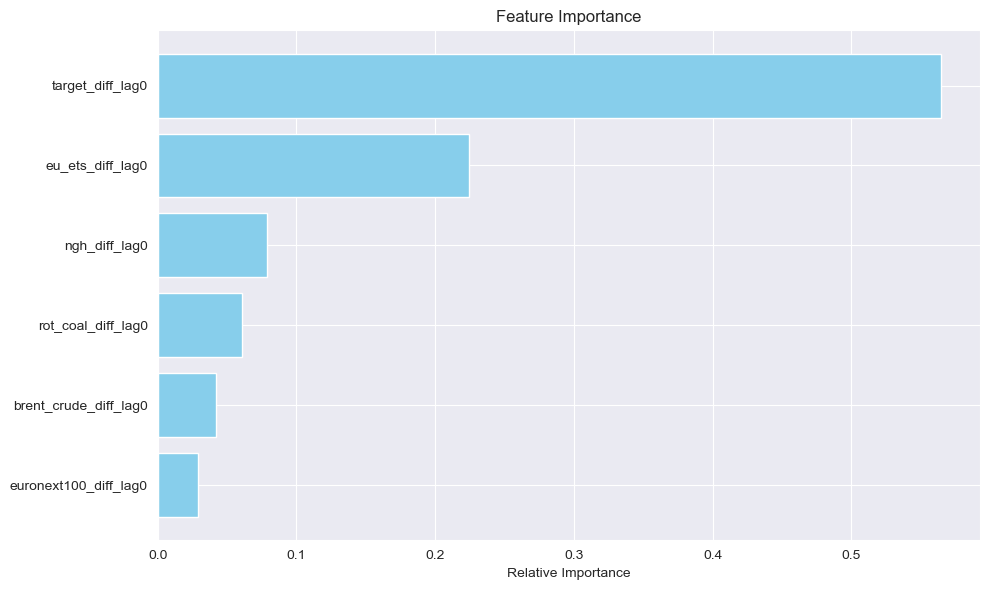


Test Set Performance (One-Day-Ahead Level Forecasts):
  MAE: 0.7225
  RMSE: 1.2557
  R2 Score: 0.9973


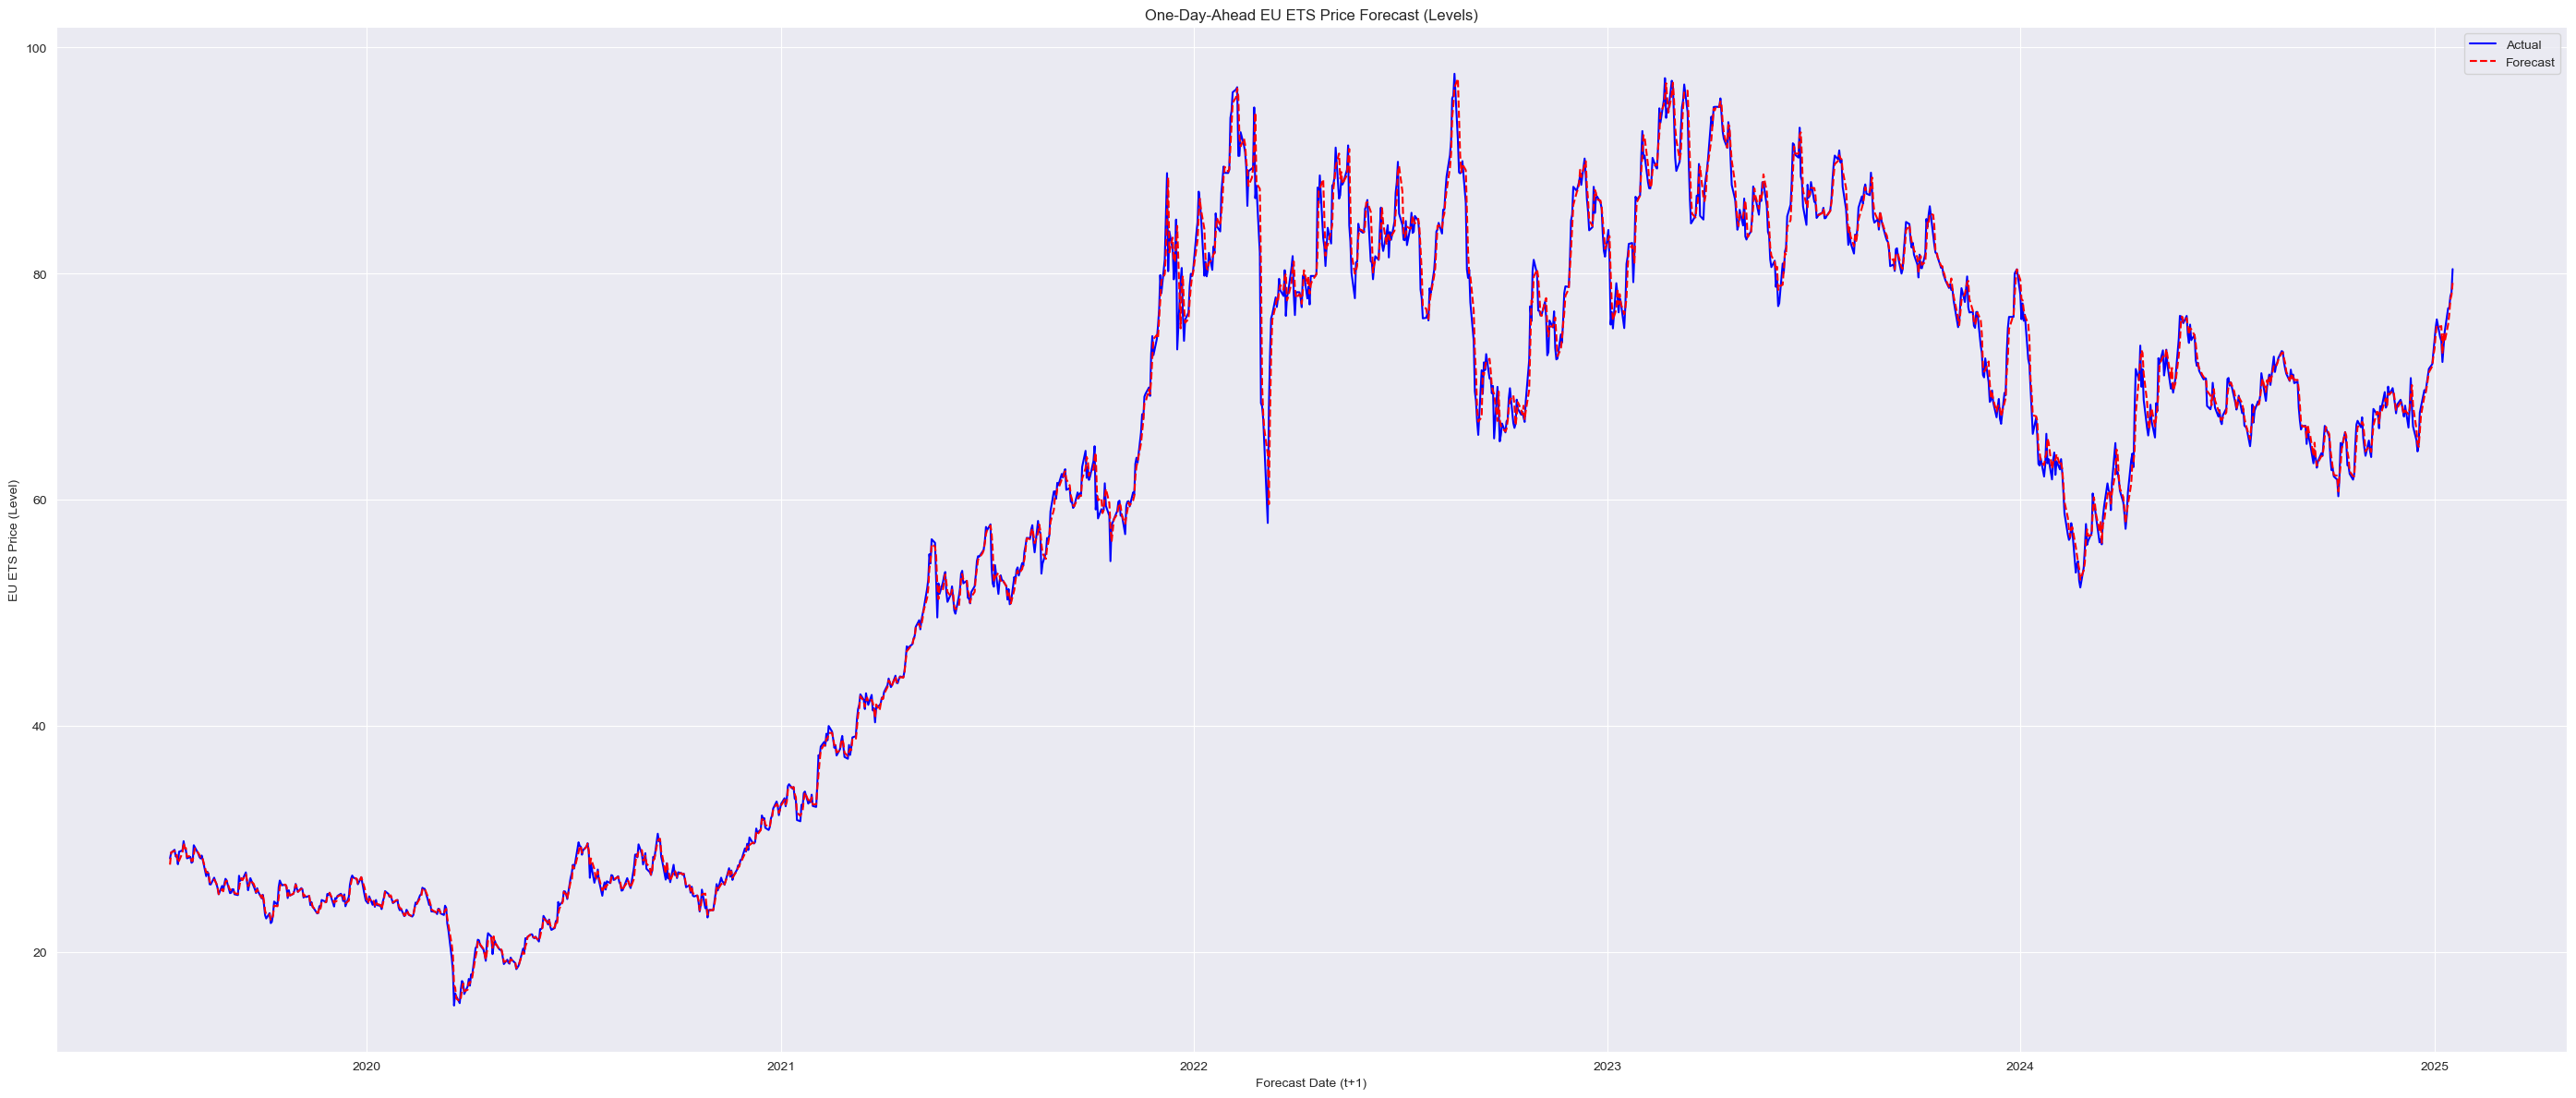

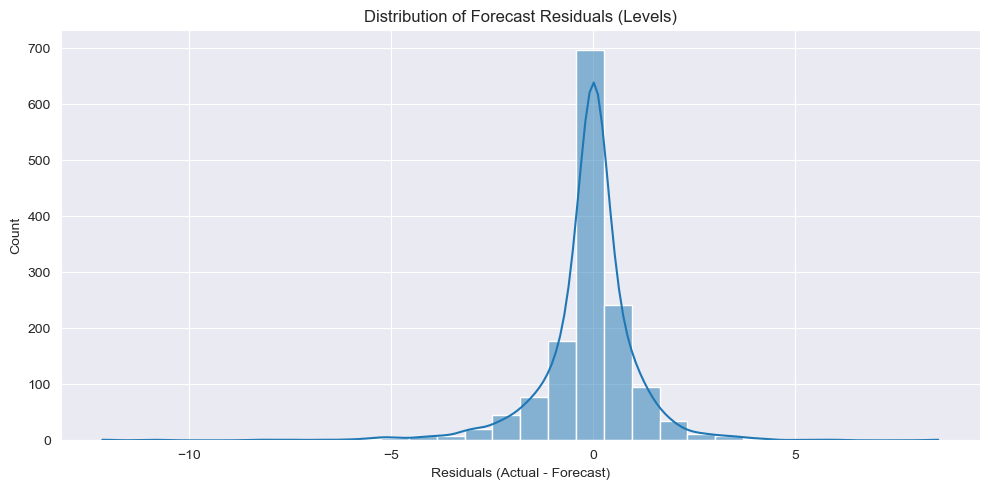

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# For reproducibility
RANDOM_STATE = 42

def load_and_prepare_data(file_path):
    """
    Loads the CSV file, parses dates, reindexes to business days, and interpolates missing data
    for non-weekend (business) days. Then creates differenced columns.

    The original 'eu_ets' values are stored in 'eu_ets_level' for forecast reconstruction.
    In addition, we add:
      - forecast_date: the date corresponding to t+1 (next business day)
      - actual_level: the true eu_ets_level for t+1
    The target is defined as:
      target = actual_level - eu_ets_level
    """
    # Read the CSV, parse dates (dayfirst=True for %d/%m/%Y format), sort, and reset index.
    df = pd.read_csv(file_path, parse_dates=['date'], dayfirst=True)
    df.sort_values('date', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Set the date as index and reindex to business days.
    df.set_index('date', inplace=True)
    all_bdays = pd.date_range(start=df.index.min(), end=df.index.max(), freq='B')
    df = df.reindex(all_bdays)

    # Interpolate missing numeric values (only business days are in the index).
    df = df.apply(lambda x: x.interpolate(method='linear') if x.dtype.kind in 'biufc' else x)

    # Reset index and rename it back to 'date'
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'date'}, inplace=True)

    # Save original EU ETS values for forecast reconstruction.
    df['eu_ets_level'] = df['eu_ets']

    # Create forecast_date using a business day offset (t+1) and compute actual_level via a row shift.
    df['forecast_date'] = df['date'] + pd.tseries.offsets.BDay(1)
    df['actual_level'] = df['eu_ets_level'].shift(-1)

    # Define the target: change from current level to next business day level.
    df['target'] = df['actual_level'] - df['eu_ets_level']

    # Identify columns to difference (all except those we want to keep).
    cols_to_diff = [col for col in df.columns
                    if col not in ['date', 'eu_ets_level', 'forecast_date', 'actual_level']]
    for col in cols_to_diff:
        diff_col = col + '_diff'
        df[diff_col] = df[col] - df[col].shift(1)

    # Drop rows with NaN values (those from shifting and at the tail of the series).
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

def create_lag_features(df, n_lags):
    """
    For each differenced column (except the target), create lag features.
    Also, carry along the forecast_date, base level (eu_ets_level), and actual_level.

    Returns:
      X: feature matrix for modeling,
      y: target (next day's change),
      forecast_dates: the date corresponding to t+1,
      base_levels: the eu_ets_level at time t,
      actual_levels: the eu_ets_level at time t+1.
    """
    features = pd.DataFrame(index=df.index)
    # Select all differenced columns except the target.
    diff_cols = [col for col in df.columns if col.endswith('_diff') and col != 'target']
    for col in diff_cols:
        for lag in range(n_lags):
            features[f"{col}_lag{lag}"] = df[col].shift(lag)

    # Determine valid indices (rows where all lag features exist).
    valid_idx = features.dropna().index

    # Use these indices to extract target and extra columns.
    X = features.loc[valid_idx]
    y = df.loc[valid_idx, 'target']
    forecast_dates = df.loc[valid_idx, 'forecast_date']
    base_levels = df.loc[valid_idx, 'eu_ets_level']
    actual_levels = df.loc[valid_idx, 'actual_level']

    return X, y, forecast_dates, base_levels, actual_levels

def objective(trial, df_train):
    """
    Optuna objective function that tunes both Random Forest hyperparameters and the number of lags.
    """
    n_lags = trial.suggest_int("lags", 1, 10)
    X, y, _, _, _ = create_lag_features(df_train, n_lags)
    X_np = X.values
    y_np = y.values

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "random_state": RANDOM_STATE,
        "n_jobs": -1
    }

    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_index, val_index in tscv.split(X_np):
        X_tr, X_val = X_np[train_index], X_np[val_index]
        y_tr, y_val = y_np[train_index], y_np[val_index]

        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr)
        X_val_scaled = scaler.transform(X_val)

        model = RandomForestRegressor(**params)
        model.fit(X_tr_scaled, y_tr)
        y_pred = model.predict(X_val_scaled)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

def main():
    # 1. Load and prepare the data.
    file_path = 'data/clean_euros_data_v3.csv'
    df = load_and_prepare_data(file_path)

    # (Optional) Keep original info for reference.
    original_info = df[['date', 'eu_ets_level']].copy()

    # 2. Create a chronological train-test split (e.g., 70/30 split).
    split_index = int(len(df) * 0.7)
    df_train = df.iloc[:split_index].reset_index(drop=True)
    df_test  = df.iloc[split_index:].reset_index(drop=True)

    # 3. Hyperparameter optimization with Optuna (including lag length).
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, df_train), n_trials=50)

    print("Best trial:")
    best_trial = study.best_trial
    for key, value in best_trial.params.items():
        print(f"  {key}: {value}")
    print(f"  Best CV RMSE: {best_trial.value:.4f}")

    # 4. Train the final model on the entire training set using the best parameters.
    best_n_lags = best_trial.params["lags"]
    X_train, y_train, _, _, _ = create_lag_features(df_train, best_n_lags)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.values)

    final_model = RandomForestRegressor(
        n_estimators=best_trial.params["n_estimators"],
        max_depth=best_trial.params["max_depth"],
        min_samples_split=best_trial.params["min_samples_split"],
        min_samples_leaf=best_trial.params["min_samples_leaf"],
        max_features=best_trial.params["max_features"],
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    final_model.fit(X_train_scaled, y_train.values)

    # --- Plot Relative Feature Importance (optional) ---
    feature_importances = final_model.feature_importances_
    feature_names = X_train.columns
    feat_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=True)
    plt.figure(figsize=(10, 6))
    plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='skyblue')
    plt.xlabel("Relative Importance")
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()

    # 5. Forecast on the test set.
    X_test, y_test, forecast_dates, base_levels, actual_levels = create_lag_features(df_test, best_n_lags)
    X_test_scaled = scaler.transform(X_test.values)
    y_pred_diff = final_model.predict(X_test_scaled)

    # Reconstruct level forecasts:
    # For each row, the forecasted level at t+1 is:
    # base level (at time t) + predicted one-day difference.
    forecast_levels = base_levels + y_pred_diff

    # 6. Evaluate forecasts.
    mae = mean_absolute_error(actual_levels, forecast_levels)
    rmse = np.sqrt(mean_squared_error(actual_levels, forecast_levels))
    r2 = r2_score(actual_levels, forecast_levels)
    print("\nTest Set Performance (One-Day-Ahead Level Forecasts):")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R2 Score: {r2:.4f}")

    # 7. Graphical evaluation of forecasts using the forecast_date (t+1).
    plt.figure(figsize=(28, 12))
    plt.plot(forecast_dates, actual_levels, label="Actual", color="blue")
    plt.plot(forecast_dates, forecast_levels, label="Forecast", color="red", linestyle="--")
    plt.xlabel("Forecast Date (t+1)")
    plt.ylabel("EU ETS Price (Level)")
    plt.title("One-Day-Ahead EU ETS Price Forecast (Levels)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot residuals.
    residuals = actual_levels - forecast_levels
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals, kde=True, bins=30)
    plt.xlabel("Residuals (Actual - Forecast)")
    plt.title("Distribution of Forecast Residuals (Levels)")
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()


One-Week ahead forecasts

[I 2025-02-05 20:32:23,716] A new study created in memory with name: no-name-f4aa93f7-2a7a-4287-8109-48d2b546e6f3
[I 2025-02-05 20:32:24,101] Trial 0 finished with value: 0.7699810266704162 and parameters: {'lags': 1, 'n_estimators': 76, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7699810266704162.
[I 2025-02-05 20:32:24,924] Trial 1 finished with value: 0.7962769011267721 and parameters: {'lags': 1, 'n_estimators': 175, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7699810266704162.
[I 2025-02-05 20:32:25,840] Trial 2 finished with value: 0.7701725728964208 and parameters: {'lags': 1, 'n_estimators': 222, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7699810266704162.
[I 2025-02-05 20:32:26,867] Trial 3 finished with value: 0.76305388323271 and parameters: {'lags': 1, 

Best trial:
  lags: 1
  n_estimators: 200
  max_depth: 10
  min_samples_split: 4
  min_samples_leaf: 5
  max_features: log2
  Best CV RMSE: 0.7559


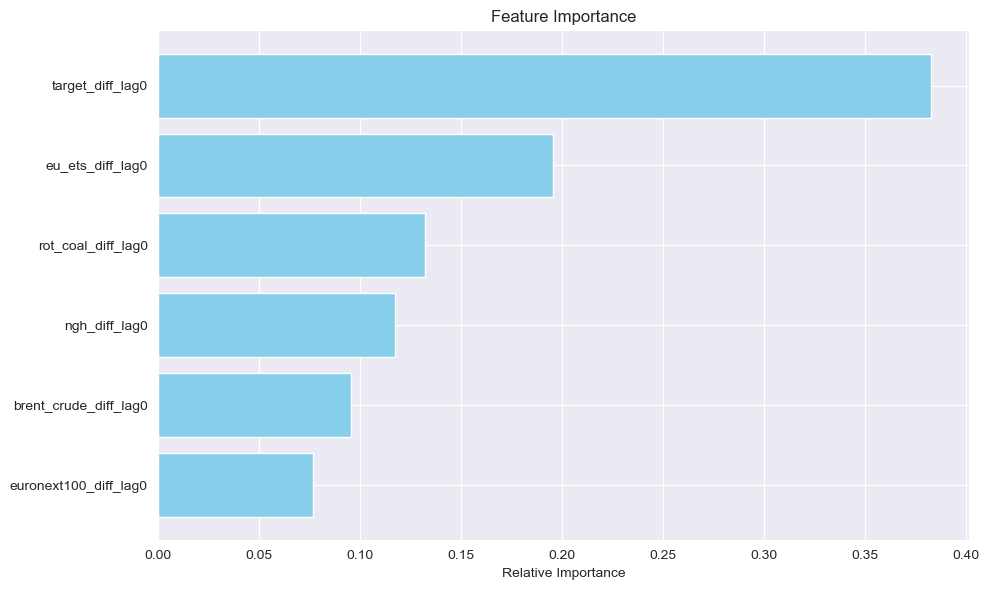


Test Set Performance (Week-Ahead Level Forecasts):
  MAE: 3.1347
  RMSE: 4.1741
  R2 Score: 0.8682


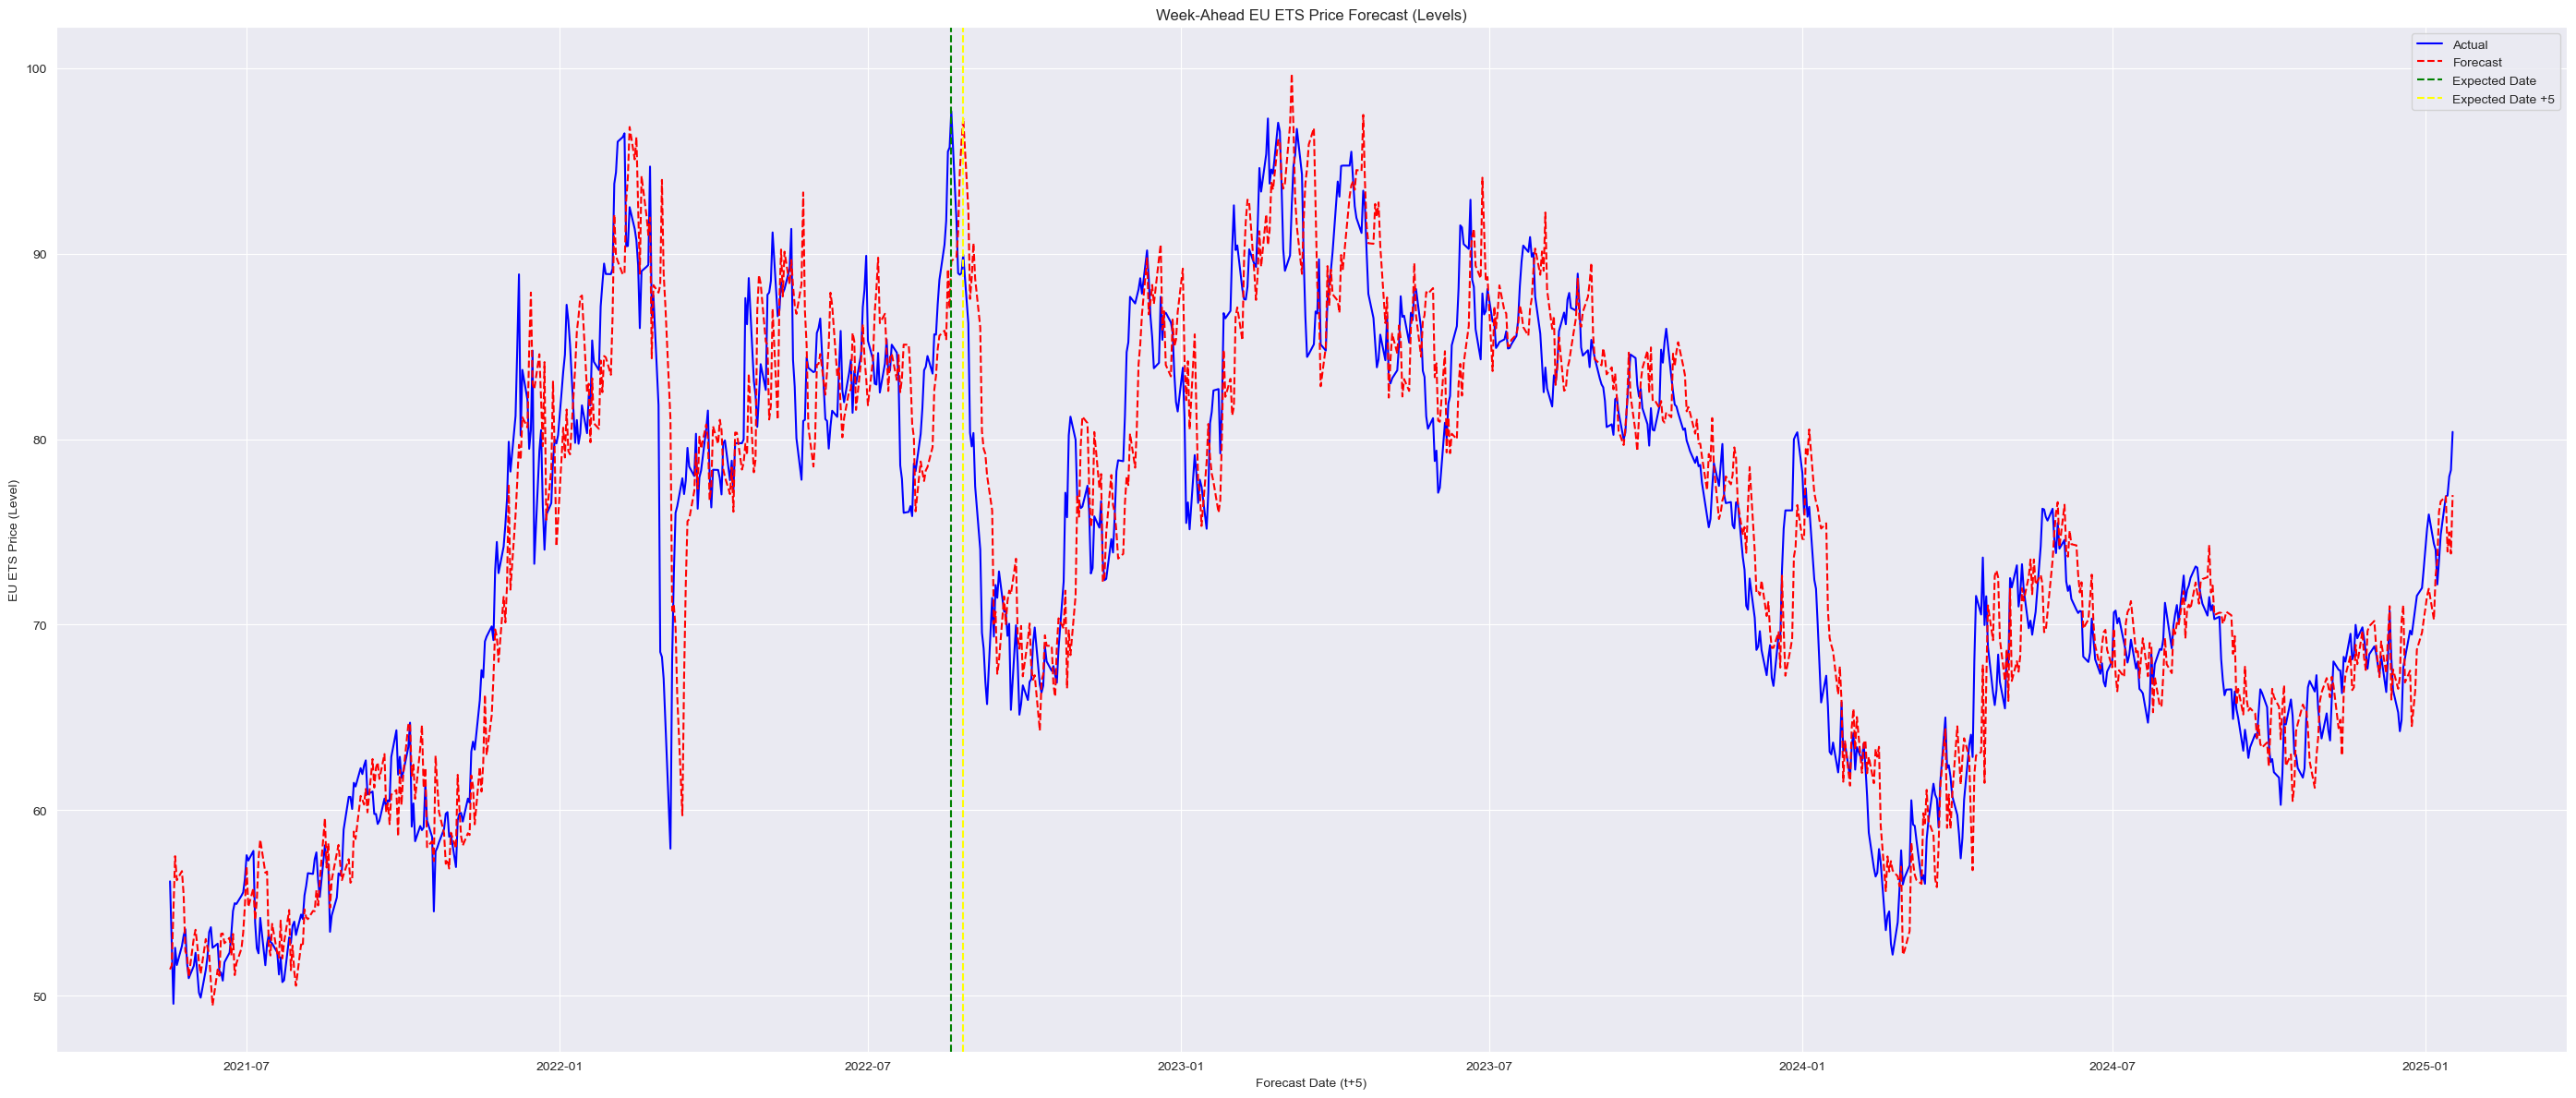

Forecast Dates:
0   2021-05-17
1   2021-05-18
2   2021-05-19
3   2021-05-20
4   2021-05-21
5   2021-05-24
6   2021-05-25
7   2021-05-26
8   2021-05-27
9   2021-05-28
Name: forecast_date, dtype: datetime64[ns]


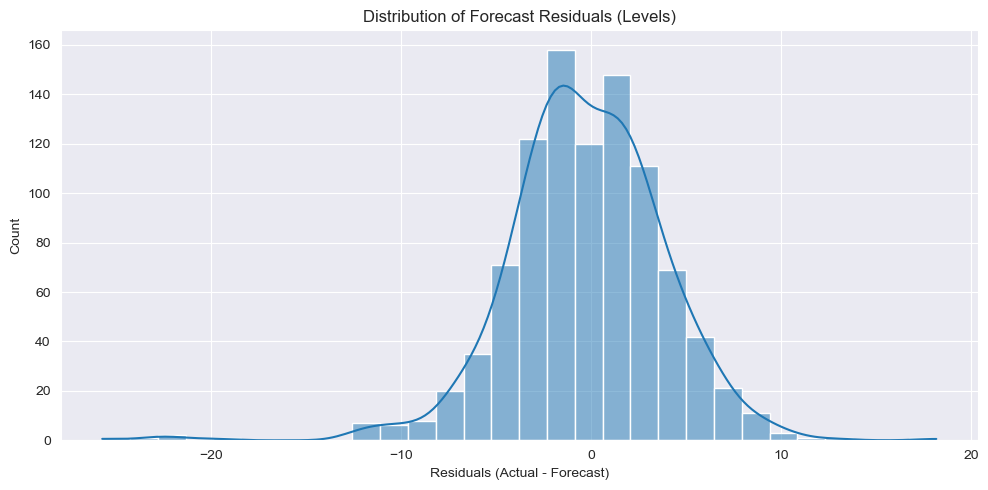

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# For reproducibility
RANDOM_STATE = 42

def load_and_prepare_data(file_path):
    """
    Loads the CSV file, parses dates, reindexes to business days, and interpolates missing numeric data.
    The original 'eu_ets' values are stored in 'eu_ets_level' for forecast reconstruction.

    In addition, we add:
      - forecast_date: the date corresponding to t+5 (week ahead in business days)
      - actual_level: the true eu_ets_level for t+5
    The target is defined as:
      target = actual_level - eu_ets_level
    """
    # Read the CSV (dates in %d/%m/%Y format)
    df = pd.read_csv(file_path, parse_dates=['date'], dayfirst=True)
    df.sort_values('date', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Set date as index and reindex to business days (weekends are not added)
    df.set_index('date', inplace=True)
    bdays = pd.date_range(start=df.index.min(), end=df.index.max(), freq='B')
    df = df.reindex(bdays)

    # Interpolate missing numeric values (only for columns that are numeric)
    df = df.apply(lambda x: x.interpolate(method='linear') if x.dtype.kind in 'biufc' else x)

    # Reset index and rename it back to 'date'
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'date'}, inplace=True)

    # Save the original EU ETS values for later forecast reconstruction.
    df['eu_ets_level'] = df['eu_ets']

    # For a week-ahead forecast, we use 5 business days.
    df['forecast_date'] = df['date'] + pd.tseries.offsets.BDay(5)
    df['actual_level'] = df['eu_ets_level'].shift(-5)

    # Define the target as the change from current level to the level 5 business days later.
    df['target'] = df['actual_level'] - df['eu_ets_level']

    # Identify columns to difference (all columns except those we wish to keep)
    keep_cols = ['date', 'eu_ets_level', 'forecast_date', 'actual_level']
    cols_to_diff = [col for col in df.columns if col not in keep_cols]
    for col in cols_to_diff:
        diff_col = col + '_diff'
        df[diff_col] = df[col] - df[col].shift(1)

    # Drop rows with NaN values (from shifting and at the tail due to forecast/actual shift)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

def create_lag_features(df, n_lags):
    """
    For each differenced column (except the target), create lag features.
    Also, carry along the forecast_date, the base level (eu_ets_level), and the actual_level.

    Returns:
      X: feature matrix for modeling,
      y: target (week-ahead change),
      forecast_dates: the date corresponding to t+5,
      base_levels: the eu_ets_level at time t,
      actual_levels: the eu_ets_level at time t+5.
    """
    features = pd.DataFrame(index=df.index)
    # Select all differenced columns except the target
    diff_cols = [col for col in df.columns if col.endswith('_diff') and col != 'target']
    for col in diff_cols:
        for lag in range(n_lags):
            features[f"{col}_lag{lag}"] = df[col].shift(lag)

    # Use dropna on the features to determine valid indices.
    valid_idx = features.dropna().index

    # Extract the feature matrix and extra columns using the same indices.
    X = features.loc[valid_idx]
    y = df.loc[valid_idx, 'target']
    forecast_dates = df.loc[valid_idx, 'forecast_date']
    base_levels = df.loc[valid_idx, 'eu_ets_level']
    actual_levels = df.loc[valid_idx, 'actual_level']

    return X, y, forecast_dates, base_levels, actual_levels

def objective(trial, df_train):
    """
    Optuna objective function that tunes both Random Forest hyperparameters and the number of lags.
    """
    n_lags = trial.suggest_int("lags", 1, 1)
    X, y, _, _, _ = create_lag_features(df_train, n_lags)
    X_np = X.values
    y_np = y.values

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "random_state": RANDOM_STATE,
        "n_jobs": -1
    }

    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_index, val_index in tscv.split(X_np):
        X_tr, X_val = X_np[train_index], X_np[val_index]
        y_tr, y_val = y_np[train_index], y_np[val_index]

        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr)
        X_val_scaled = scaler.transform(X_val)

        model = RandomForestRegressor(**params)
        model.fit(X_tr_scaled, y_tr)
        y_pred = model.predict(X_val_scaled)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

def main():
    # 1. Load and prepare the data.
    file_path = 'data/clean_euros_data_v3.csv'
    df = load_and_prepare_data(file_path)

    # Optionally keep original info for reference.
    original_info = df[['date', 'eu_ets_level']].copy()

    # 2. Create a chronological train-test split (e.g., 80/20 split).
    split_index = int(len(df) * 0.8)
    df_train = df.iloc[:split_index].reset_index(drop=True)
    df_test  = df.iloc[split_index:].reset_index(drop=True)

    # 3. Hyperparameter optimization with Optuna (including lag length).
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, df_train), n_trials=50)

    print("Best trial:")
    best_trial = study.best_trial
    for key, value in best_trial.params.items():
        print(f"  {key}: {value}")
    print(f"  Best CV RMSE: {best_trial.value:.4f}")

    # 4. Train the final model on the entire training set using the best parameters.
    best_n_lags = best_trial.params["lags"]
    X_train, y_train, _, _, _ = create_lag_features(df_train, best_n_lags)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.values)

    final_model = RandomForestRegressor(
        n_estimators=best_trial.params["n_estimators"],
        max_depth=best_trial.params["max_depth"],
        min_samples_split=best_trial.params["min_samples_split"],
        min_samples_leaf=best_trial.params["min_samples_leaf"],
        max_features=best_trial.params["max_features"],
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    final_model.fit(X_train_scaled, y_train.values)

    # --- Optional: Plot Relative Feature Importance ---
    feature_importances = final_model.feature_importances_
    feature_names = X_train.columns
    feat_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=True)
    plt.figure(figsize=(10, 6))
    plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='skyblue')
    plt.xlabel("Relative Importance")
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()

    # 5. Forecast on the test set.
    X_test, y_test, forecast_dates, base_levels, actual_levels = create_lag_features(df_test, best_n_lags)
    X_test_scaled = scaler.transform(X_test.values)
    y_pred_diff = final_model.predict(X_test_scaled)

    # Reconstruct level forecasts:
    # For each row, the forecasted level at t+5 is:
    # base level (at time t) + predicted week-ahead difference.
    forecast_levels = base_levels + y_pred_diff

    # 6. Evaluate forecasts.
    mae = mean_absolute_error(actual_levels, forecast_levels)
    rmse = np.sqrt(mean_squared_error(actual_levels, forecast_levels))
    r2 = r2_score(actual_levels, forecast_levels)
    print("\nTest Set Performance (Week-Ahead Level Forecasts):")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R2 Score: {r2:.4f}")

    # 7. Graphical evaluation of forecasts using the forecast_date (t+5).
    plt.figure(figsize=(28, 12))
    plt.plot(forecast_dates, actual_levels, label="Actual", color="blue")
    plt.plot(forecast_dates, forecast_levels, label="Forecast", color="red", linestyle="--")
    plt.xlabel("Forecast Date (t+5)")
    plt.ylabel("EU ETS Price (Level)")
    plt.title("Week-Ahead EU ETS Price Forecast (Levels)")
    expected_date = pd.Timestamp('2022-08-19')
    plt.axvline(x=expected_date, color='green', linestyle='--', label='Expected Date')
    expected_date_2 = pd.Timestamp('2022-08-26')
    plt.axvline(x=expected_date_2, color='yellow', linestyle='--', label='Expected Date +5')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("Forecast Dates:")
    print(forecast_dates.head(10))

    # Plot residuals.
    residuals = actual_levels - forecast_levels
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals, kde=True, bins=30)
    plt.xlabel("Residuals (Actual - Forecast)")
    plt.title("Distribution of Forecast Residuals (Levels)")
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()


Dynamic One Day ahead forecast

[I 2025-02-06 21:49:26,607] A new study created in memory with name: no-name-6b45af3f-020f-4980-97db-555c4743c547


Data loaded. DataFrame shape: (4804, 14)


`start` time `2006-08-28 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Using the first historical forecasting point `2006-08-31 00:00:00` that lies a round-multiple of `stride=1` ahead of `start`. To hide these warnings, set `show_warnings=False`.
[I 2025-02-06 21:49:26,951] Trial 0 finished with value: 0.4264301366657797 and parameters: {'lags': 8, 'n_estimators': 196, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.4264301366657797.
[I 2025-02-06 21:49:27,147] Trial 1 finished with value: 0.43395093721608435 and parameters: {'lags': 5, 'n_estimators': 71, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.4264301366657797.
`start` time `2006-08-28 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Using the first historical forecasting po

Best hyperparameters: {'lags': 1, 'n_estimators': 250, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`start` position `0.0` corresponding to time `2019-07-10 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Using the first historical forecasting point `2019-07-15 00:00:00` that lies a round-multiple of `stride=1` ahead of `start`. To hide these warnings, set `show_warnings=False`.


historical forecasts:   0%|          | 0/1439 [00:00<?, ?it/s]

Forecasting complete.
Test MAE: 1.2618492152407639
Test RMSE: 1.8976181936701595
Test R2: 0.9937692701949311


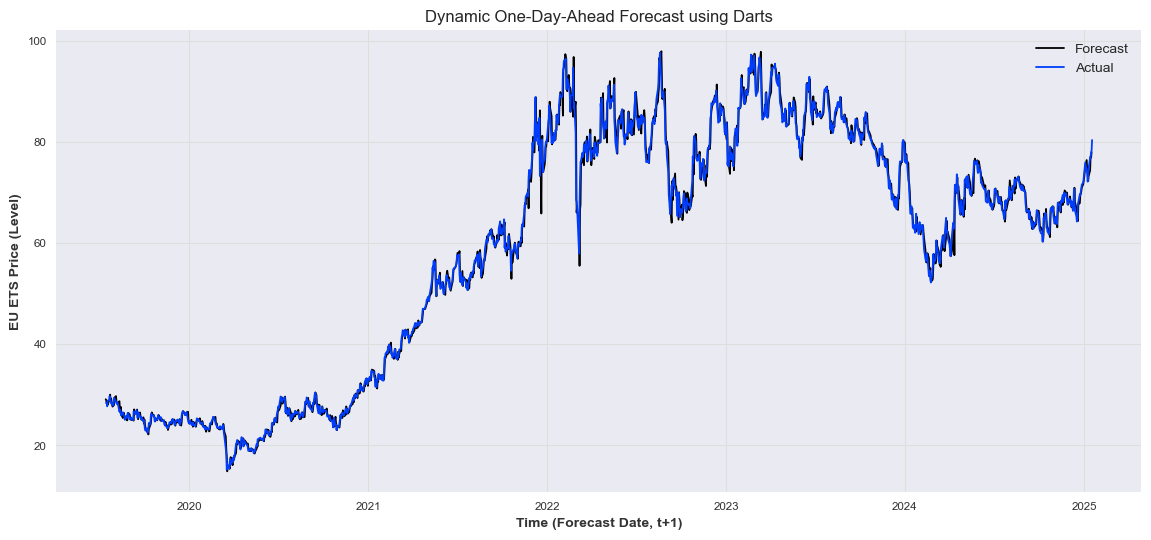

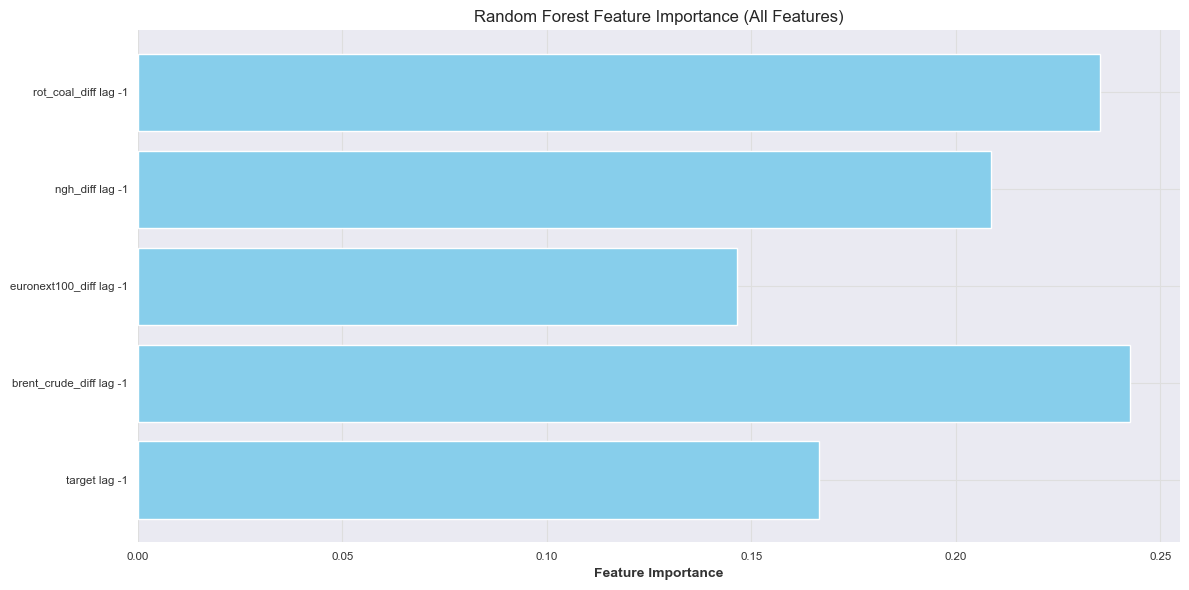

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna

from darts import TimeSeries
from darts.models import RegressionModel
from darts.metrics import mae, rmse, r2_score
from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE = 42

# Load the CSV, parse dates (dayfirst=True), and sort.
file_path = "data/clean_euros_data_v3.csv"
df = pd.read_csv(file_path, parse_dates=['date'], dayfirst=True)
df.sort_values('date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Reindex to business days.
df.set_index('date', inplace=True)
all_bdays = pd.date_range(start=df.index.min(), end=df.index.max(), freq='B')
df = df.reindex(all_bdays)

# Interpolate missing numeric values.
df = df.apply(lambda x: x.interpolate(method='linear') if x.dtype.kind in 'biufc' else x)

df.reset_index(inplace=True)
df.rename(columns={'index': 'date'}, inplace=True)

# Save original eu_ets values.
df['eu_ets_level'] = df['eu_ets']

# One-day ahead forecast:
# forecast_date = date + 1 business day; actual_level = eu_ets_level shifted by -1.
df['forecast_date'] = df['date'] + pd.tseries.offsets.BDay(1)
df['actual_level'] = df['eu_ets_level'].shift(-1)
df['target'] = df['actual_level'] - df['eu_ets_level']

# Create differenced columns for any other numeric features.
keep_cols = ['date', 'eu_ets', 'eu_ets_level', 'forecast_date', 'actual_level', 'target']
cols_to_diff = [col for col in df.columns if col not in keep_cols]
for col in cols_to_diff:
    df[col + '_diff'] = df[col] - df[col].shift(1)

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Create Darts TimeSeries objects.
series_target = TimeSeries.from_dataframe(df, time_col='date', value_cols='target')
series_base   = TimeSeries.from_dataframe(df, time_col='date', value_cols='eu_ets_level')

# Create a covariate TimeSeries from all differenced columns (excluding 'target').
covariate_cols = [col for col in df.columns if col.endswith('_diff') and col != 'target']
if covariate_cols:
    series_covariates = TimeSeries.from_dataframe(df, time_col='date', value_cols=covariate_cols)
else:
    series_covariates = None

print("Data loaded. DataFrame shape:", df.shape)
df.head()

def objective(trial):
    # Tune hyperparameters.
    n_lags = trial.suggest_int("lags", 1, 10)
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])

    # Darts expects negative lags.
    lags = list(range(-n_lags, 0))

    # Build a RegressionModel with output_chunk_length=1 for day-ahead forecasting.
    model = RegressionModel(
        lags=lags,
        lags_past_covariates=lags,
        model=RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ),
        output_chunk_length=1
    )

    forecast_horizon = 1  # Day-ahead forecast
    n_windows = 5
    if len(series_train) <= n_windows:
        return np.inf
    # Use the (n_windows+1)th time point as start.
    start_time = series_train.time_index[n_windows]

    # Fit the model once on the training data.
    model.fit(series_train, past_covariates=series_cov_train)

    try:
        # Fixed-window mode (no retraining for each forecast origin).
        pred = model.historical_forecasts(
            series_train,
            past_covariates=series_cov_train,
            forecast_horizon=forecast_horizon,
            start=start_time,
            stride=1,
            retrain=False,
            verbose=False
        )
    except Exception as e:
        print("Error in historical_forecasts:", e)
        return np.inf

    actual = series_train.slice_intersect(pred)
    error = rmse(actual, pred)
    return error

# Split the TimeSeries into training and test sets (70/30 split).
train_cutoff = int(0.7 * len(series_target))
series_train = series_target[:train_cutoff]
series_test  = series_target[train_cutoff:]
base_test    = series_base[train_cutoff:]
if series_covariates is not None:
    series_cov_train = series_covariates[:train_cutoff]
    series_cov_test  = series_covariates[train_cutoff:]
else:
    series_cov_train = None
    series_cov_test = None

# Run hyperparameter tuning.
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)
best_params = study.best_trial.params
print("Best hyperparameters:", best_params)

# Retrieve best hyperparameters.
n_lags = best_params["lags"]
lags = list(range(-n_lags, 0))

# Train the final model on the full training set.
final_model = RegressionModel(
    lags=lags,
    lags_past_covariates=lags,
    model=RandomForestRegressor(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        min_samples_leaf=best_params["min_samples_leaf"],
        max_features=best_params["max_features"],
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    output_chunk_length=1
)
final_model.fit(series_train, past_covariates=series_cov_train)

# Forecast using an expanding-window mode (retrain=True).
forecast = final_model.historical_forecasts(
    series_test,
    past_covariates=series_cov_test,
    forecast_horizon=1,
    start=0.0,
    stride=1,
    retrain=True,
    verbose=True
)

# Reconstruct forecasted levels:
# Since target = actual_level - eu_ets_level, the forecasted level = base level + forecast.
# For day-ahead, shift the base series by 1 business day.
forecast_level = base_test.shift(1).slice_intersect(forecast) + forecast
actual_level = series_base.slice_intersect(forecast) + series_target.slice_intersect(forecast)
# For day-ahead, shifting actual_level by 1 ensures that its time index aligns with forecast_date.
actual_level = actual_level.shift(1)

print("Forecasting complete.")
print("Test MAE:", mae(actual_level, forecast_level))
print("Test RMSE:", rmse(actual_level, forecast_level))
print("Test R2:", r2_score(actual_level, forecast_level))

plt.figure(figsize=(50,20))
plt.plot(actual_level.time_index, actual_level.values(), color="blue", label="Actual")
plt.plot(forecast_level.time_index, forecast_level.values(), color="red", label="Forecast", linestyle="--")
plt.xlabel("Time (Forecast Date, t+1)")
plt.ylabel("EU ETS Price (Level)")
plt.title("Dynamic One-Day-Ahead Forecast using Darts")
plt.legend()
plt.show()

# Build labels for target lags.
lags_for_plot = lags  # same as used in the model
target_feature_names = [f"target lag {lag}" for lag in lags_for_plot]
all_feature_names = target_feature_names.copy()

# If covariates exist, add labels for each covariate's lags.
if series_covariates is not None:
    covariate_cols = list(series_covariates.columns)
    for cov in covariate_cols:
        for lag in lags_for_plot:
            all_feature_names.append(f"{cov} lag {lag}")

# Get feature importances from the RandomForestRegressor.
importances = final_model.model.feature_importances_

if len(all_feature_names) != len(importances):
    print("Warning: Mismatch in feature names and importances.")
    print(f"Feature names: {len(all_feature_names)}, importances: {len(importances)}")

plt.figure(figsize=(12, 6))
plt.barh(all_feature_names, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance (All Features)")
plt.tight_layout()
plt.show()


One-week ahead dynamic forecast


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna

from darts import TimeSeries
from darts.models import RegressionModel
from darts.metrics import mae, rmse, r2_score
from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE = 42

# Load CSV data, parse dates (dayfirst=True), reindex to business days, and interpolate missing values.
# Then compute:
#   - eu_ets_level: copy of original 'eu_ets'
#   - forecast_date: date + 5 business days
#   - actual_level: eu_ets_level shifted by -5
#   - target: actual_level - eu_ets_level
# Also create differenced columns for other numeric features.

file_path = "data/clean_euros_data_v3.csv"

# Read and sort the data.
df = pd.read_csv(file_path, parse_dates=['date'], dayfirst=True)
df.sort_values('date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Reindex to business days.
df.set_index('date', inplace=True)
all_bdays = pd.date_range(start=df.index.min(), end=df.index.max(), freq='B')
df = df.reindex(all_bdays)

# Interpolate missing numeric values.
df = df.apply(lambda x: x.interpolate(method='linear') if x.dtype.kind in 'biufc' else x)

df.reset_index(inplace=True)
df.rename(columns={'index': 'date'}, inplace=True)

# Save original eu_ets values.
df['eu_ets_level'] = df['eu_ets']

# Compute week-ahead values:
df['forecast_date'] = df['date'] + pd.tseries.offsets.BDay(5)
df['actual_level'] = df['eu_ets_level'].shift(-5)
df['target'] = df['actual_level'] - df['eu_ets_level']

# Create differenced columns for any other numeric features.
keep_cols = ['date', 'eu_ets', 'eu_ets_level', 'forecast_date', 'actual_level', 'target']
cols_to_diff = [col for col in df.columns if col not in keep_cols]
for col in cols_to_diff:
    df[col + '_diff'] = df[col] - df[col].shift(1)

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Create Darts TimeSeries objects.
series_target = TimeSeries.from_dataframe(df, time_col='date', value_cols='target')
series_base   = TimeSeries.from_dataframe(df, time_col='date', value_cols='eu_ets_level')

# Create covariate TimeSeries from all differenced columns (excluding 'target').
covariate_cols = [col for col in df.columns if col.endswith('_diff') and col != 'target']
if covariate_cols:
    series_covariates = TimeSeries.from_dataframe(df, time_col='date', value_cols=covariate_cols)
else:
    series_covariates = None

# Print some info.
print("Data loaded. DataFrame shape:", df.shape)
df.head()

def objective(trial):
    # Tune hyperparameters.
    n_lags = trial.suggest_int("lags", 1, 10)
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])

    # Darts requires negative lags.
    lags = list(range(-n_lags, 0))

    # Build model with output_chunk_length=5 for week-ahead forecasting.
    model = RegressionModel(
        lags=lags,
        lags_past_covariates=lags,
        model=RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ),
        output_chunk_length=5
    )

    forecast_horizon = 5
    n_windows = 5
    if len(series_train) <= n_windows:
        return np.inf
    # Use the (n_windows+1)th time point as start.
    start_time = series_train.time_index[n_windows]

    # Fit the model once on the training data.
    model.fit(series_train, past_covariates=series_cov_train)

    try:
        # Fixed-window mode: do not retrain for each forecast origin.
        pred = model.historical_forecasts(
            series_train,
            past_covariates=series_cov_train,
            forecast_horizon=forecast_horizon,
            start=start_time,
            stride=1,
            retrain=False,
            verbose=False
        )
    except Exception as e:
        print("Error in historical_forecasts:", e)
        return np.inf

    actual = series_train.slice_intersect(pred)
    error = rmse(actual, pred)
    return error

# Split the TimeSeries into training and test sets (70/30 split).
train_cutoff = int(0.7 * len(series_target))
series_train = series_target[:train_cutoff]
series_test  = series_target[train_cutoff:]
base_test    = series_base[train_cutoff:]
if series_covariates is not None:
    series_cov_train = series_covariates[:train_cutoff]
    series_cov_test  = series_covariates[train_cutoff:]
else:
    series_cov_train = None
    series_cov_test = None

# Run hyperparameter tuning.
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)
best_params = study.best_trial.params
print("Best hyperparameters:", best_params)

# Retrieve best hyperparameters.
n_lags = best_params["lags"]
lags = list(range(-n_lags, 0))

# Train the final model on the full training set.
final_model = RegressionModel(
    lags=lags,
    lags_past_covariates=lags,
    model=RandomForestRegressor(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        min_samples_leaf=best_params["min_samples_leaf"],
        max_features=best_params["max_features"],
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    output_chunk_length=5
)
final_model.fit(series_train, past_covariates=series_cov_train)

# Perform final forecasting using an expanding window (retrain=True).
forecast = final_model.historical_forecasts(
    series_test,
    past_covariates=series_cov_test,
    forecast_horizon=5,
    start=0.0,
    stride=1,
    retrain=True,
    verbose=True
)

# Reconstruct forecasted levels.
# The target is the cumulative change over 5 business days.
forecast_level = base_test.shift(0).slice_intersect(forecast) + forecast
forecast_level = forecast_level.shift(5)

# Reconstruct actual levels: actual = base level + target.
actual_level = series_base.slice_intersect(forecast) + series_test.slice_intersect(forecast)
# Shift actual levels by 5 days for alignment with forecast_date.
actual_level = actual_level.shift(5)

print("Forecasting complete.")
print("Test MAE:", mae(actual_level, forecast_level))
print("Test RMSE:", rmse(actual_level, forecast_level))
print("Test R2:", r2_score(actual_level, forecast_level))

# Plot forecast versus actual.
plt.figure(figsize=(28,12))
plt.plot(actual_level.time_index, actual_level.values(), color="blue", label="Actual")
plt.plot(forecast_level.time_index, forecast_level.values(), color="red", label="Forecast", linestyle="--")
plt.xlabel("Time (Forecast Date, t+5)")
plt.ylabel("EU ETS Price (Level)")
plt.title("Dynamic Week-Ahead Forecast (5 Business Days Ahead)")
plt.legend()
plt.show()

# Build labels for target lags.
lags_for_plot = lags  # same as used in the model
target_feature_names = [f"target lag {lag}" for lag in lags_for_plot]
all_feature_names = target_feature_names.copy()

# If covariates exist, add labels for each covariate's lags.
if series_covariates is not None:
    covariate_cols = list(series_covariates.columns)
    for cov in covariate_cols:
        for lag in lags_for_plot:
            all_feature_names.append(f"{cov} lag {lag}")

# Get feature importances from the underlying RandomForestRegressor.
importances = final_model.model.feature_importances_

# Check for mismatches.
if len(all_feature_names) != len(importances):
    print("Warning: Mismatch in feature names and importances.")
    print(f"Feature names: {len(all_feature_names)}, importances: {len(importances)}")

plt.figure(figsize=(12, 6))
plt.barh(all_feature_names, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance (All Features)")
plt.tight_layout()
plt.show()


ValueError: cannot reindex on an axis with duplicate labels

Forecasting complete.
Test MAE: 1.2015365508265667
Test RMSE: 1.7497431310689255
Test R2: 0.9947017568542971


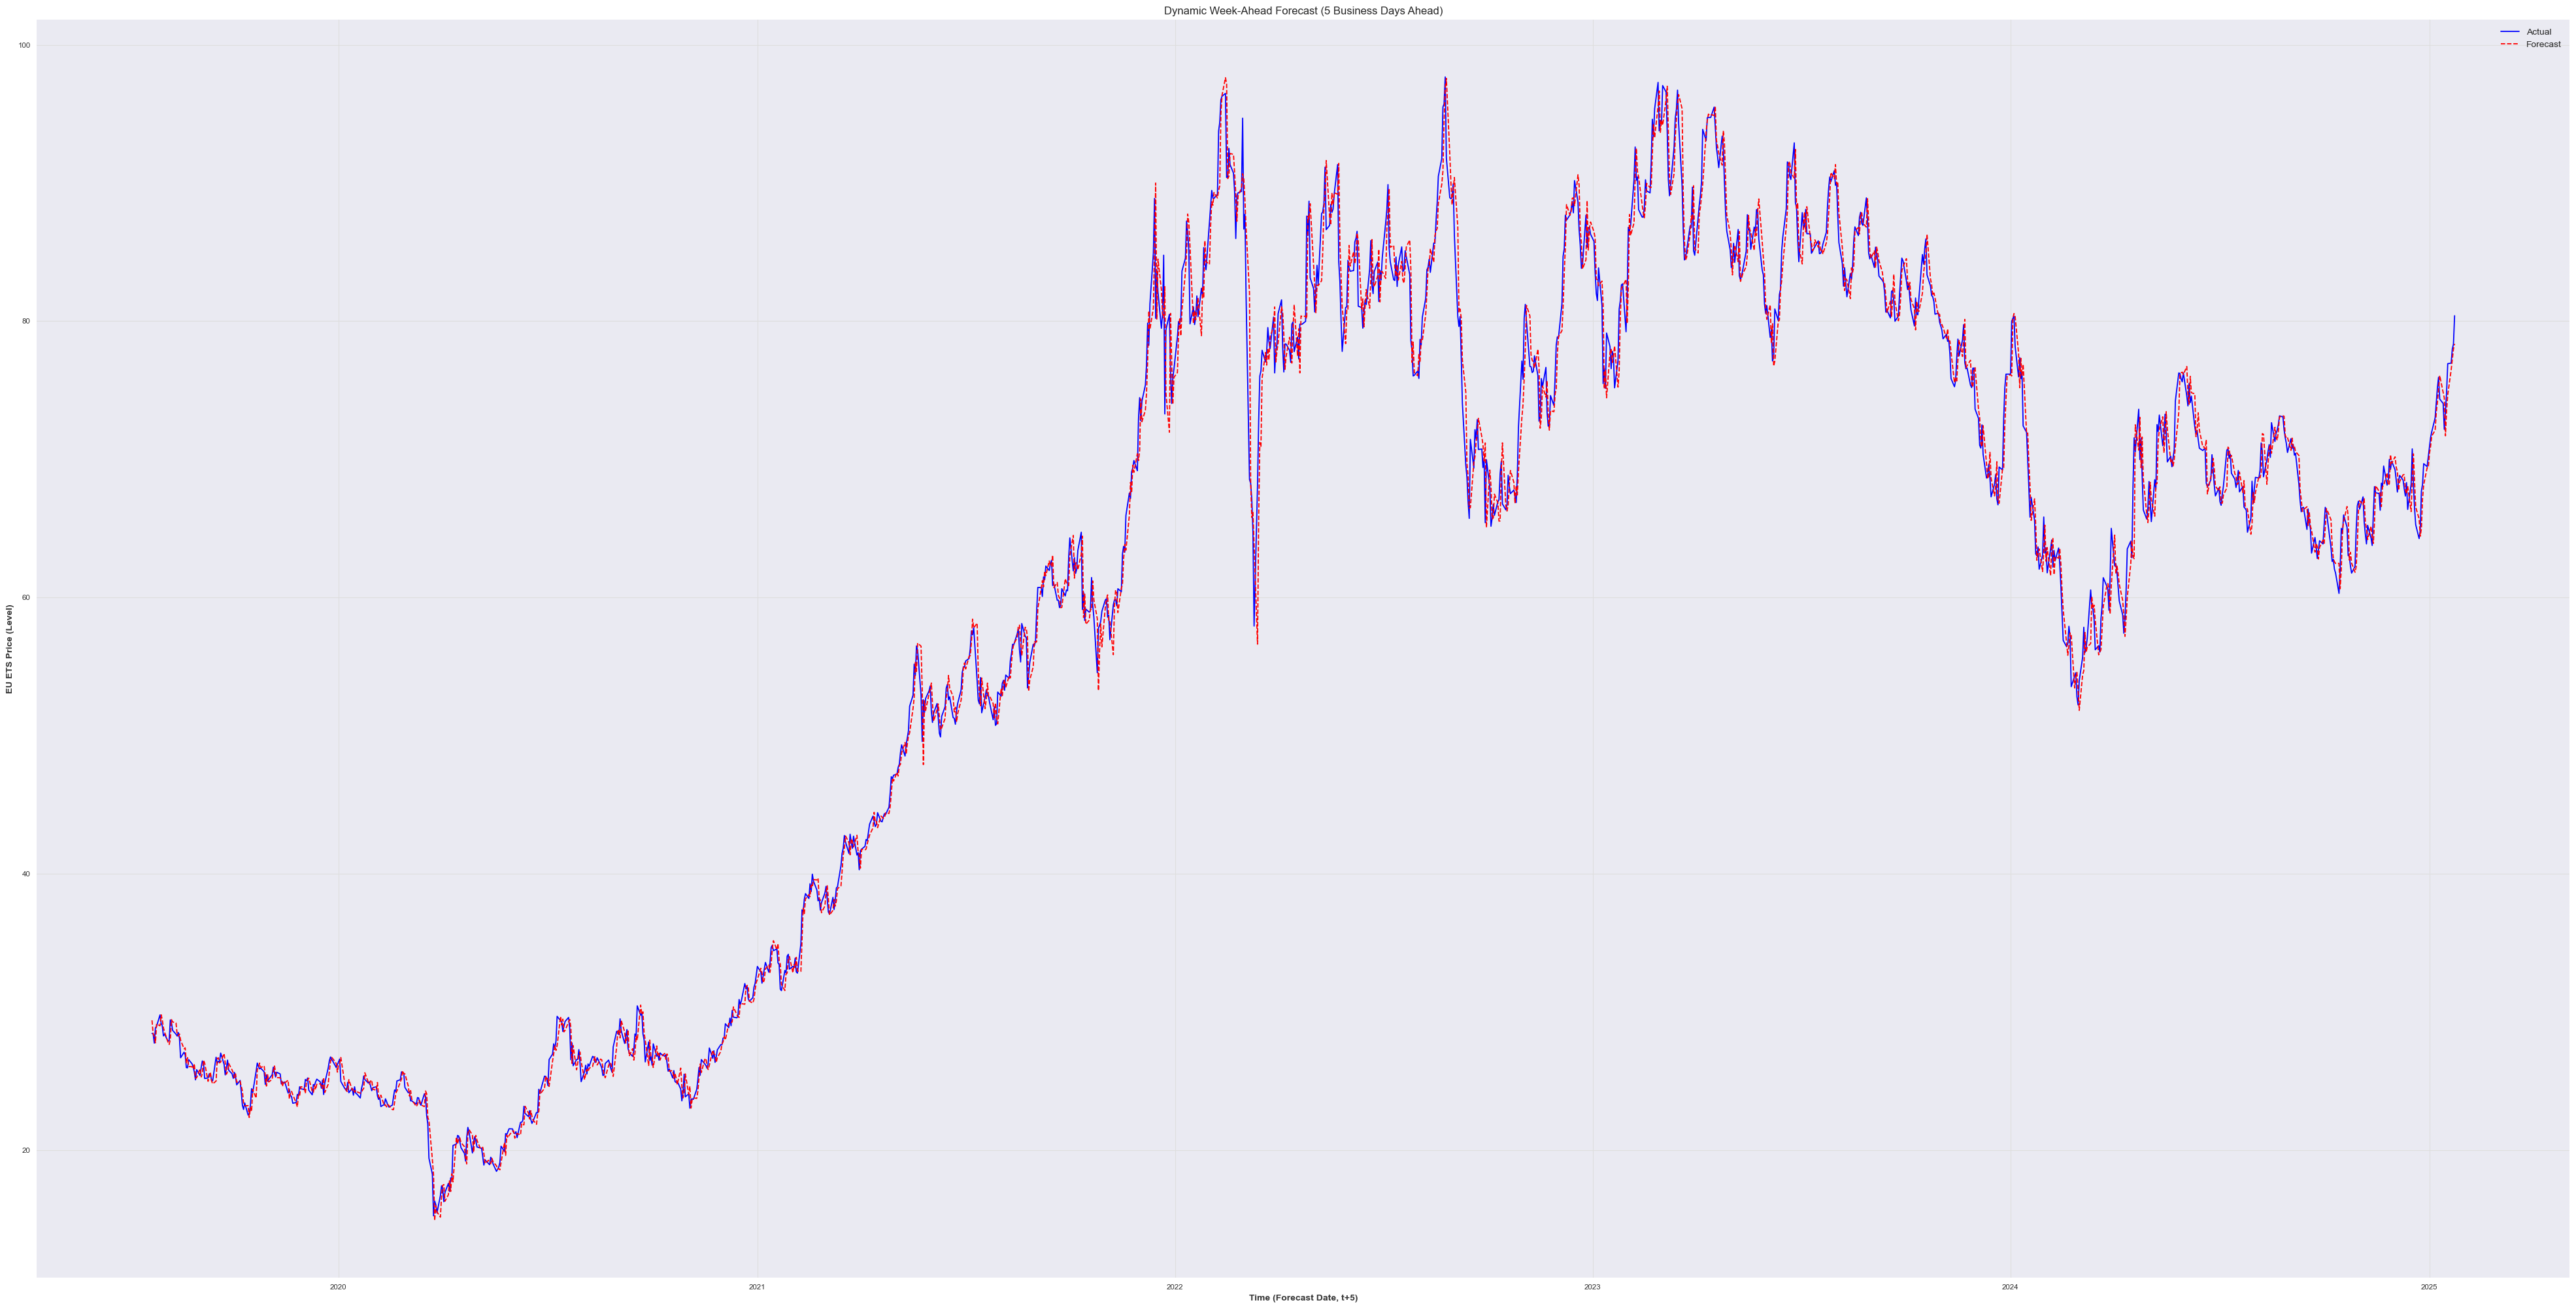

In [56]:
# The target is the cumulative change over 5 business days.
forecast_level = base_test.shift(0).slice_intersect(forecast) + forecast
forecast_level = forecast_level.shift(5)

# Reconstruct actual levels: actual = base level + target.
actual_level = series_base.slice_intersect(forecast) + series_test.slice_intersect(forecast)
# Shift actual levels by 5 days for alignment with forecast_date.
actual_level = actual_level.shift(5)

print("Forecasting complete.")
print("Test MAE:", mae(actual_level, forecast_level))
print("Test RMSE:", rmse(actual_level, forecast_level))
print("Test R2:", r2_score(actual_level, forecast_level))

# Plot forecast versus actual.
plt.figure(figsize=(50,25))
plt.plot(actual_level.time_index, actual_level.values(), color="blue", label="Actual")
plt.plot(forecast_level.time_index, forecast_level.values(), color="red", label="Forecast", linestyle="--")
plt.xlabel("Time (Forecast Date, t+5)")
plt.ylabel("EU ETS Price (Level)")
plt.title("Dynamic Week-Ahead Forecast (5 Business Days Ahead)")
plt.legend()
plt.show()